# Deletion-specific ensemble

This notebook looks at the distribution of ranks for each method and mutation type in order to make an informed decision on which methods to use for each case. The pLDDT, differential pLDDT, BLOSUM, DeepDDG and DeMaSk procedures were translated into R from the sources below.

pLDDT, BLOSUM, DeepDDG and DeMaSk procedures are from:
* https://www.kaggle.com/code/dschettler8845/novo-esp-eli5-performant-approaches-lb-0-425 

with additional references:
* https://www.kaggle.com/code/kvigly55/plldt-and-ddg
* https://www.kaggle.com/code/lucasmorin/nesp-changes-eda-and-baseline
* https://www.kaggle.com/code/hengck23/lb0-335-deepdgg-server-benchmark

Differential pLDDT procedure is from:
* https://www.kaggle.com/code/cdeotte/difference-features-lb-0-600

with mutation PDB files from:
* https://www.kaggle.com/competitions/novozymes-enzyme-stability-prediction/discussion/361816
* https://www.kaggle.com/datasets/roberthatch/nesp-kvigly-test-mutation-pdbs

RMSD and SASA from MD simulation procedure:
* https://www.kaggle.com/code/oxzplvifi/rmsd-from-molecular-dynamics

with the following two MD simulation outputs used:
* https://www.kaggle.com/datasets/oxzplvifi/novozymes-md for SASA measurement
* https://www.kaggle.com/datasets/oxzplvifi/novozymes-md2 for RMSD measurement

The output files of Rosetta and Thermonet were loaded directly since I am not sure yet if they can be implemented in R:
* https://www.kaggle.com/code/shlomoron/nesp-relaxed-rosetta-scores for Rosetta
* https://www.kaggle.com/code/vslaykovsky/nesp-thermonet-v2 for Thermonet

## Testing set preprocessing

Record the location in the sequence of each mutation or deletion for each row as in https://www.kaggle.com/code/oxzplvifi/novozymes-in-r-blosum-deepddg-demask

In [1]:
import os

from tqdm.auto import tqdm
from scipy.stats import rankdata

import numpy as np
import pandas as pd

import Levenshtein

import matplotlib.pyplot as plt
import seaborn as sns

two_colors = sns.xkcd_palette(['red', 'bright blue'])

In [2]:
# Plot rank distributions
def plot_rank_dist(name, ax, show_del=False):

    sns.kdeplot(
        data=test_df.query('type=="SUB"'),
        x='{}_rank'.format(name),
        bw_adjust=0.3,
        lw=3,
        label='SUB',
        ax=ax,
        color='k'
    )

    ax.vlines(
        test_df.query('type=="DEL"')['{}_rank'.format(name)],
        ax.get_ylim()[0],
        ax.get_ylim()[1],
        lw=5,
        label='DEL',
        color=two_colors[0]
    )

    ax.vlines(
        test_df.query('type=="WT"')['{}_rank'.format(name)],
        ax.get_ylim()[0],
        ax.get_ylim()[1],
        lw=5,
        label='WT',
        color=two_colors[1]
    )

    if show_del:
        sns.kdeplot(
            data=test_df.query('type=="DEL"'),
            x='{}_rank'.format(name),
            bw_adjust=0.3,
            lw=3,
            label='DEL',
            ax=ax,
            color=two_colors[0]
        )

        ax.vlines(
            test_df.query('type=="DEL"')['{}_rank'.format(name)],
            ax.get_ylim()[0],
            ax.get_ylim()[1],
            lw=5,
            label='DEL',
            color=two_colors[0]
        )

    ax.set_xlim(-50,2550)
    ax.set_title('{} rank distribution'.format(name), fontsize=20)
    ax.set_xlabel('{}_rank'.format(name), fontsize=20)
    ax.set_ylabel('Density', fontsize=20)

    ax.tick_params(labelsize=12)
    ax.legend(loc=1)

    return ax

In [3]:
# Wild type sequence provided in the "Dataset Description":
wt = 'VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK'

# Read testing set sequences and pH:
test_df = pd.read_csv('data/test.csv')

# Add mutation information to testing set:
result = []
for _, row in test_df.iterrows():
    ops = Levenshtein.editops(wt, row['protein_sequence'])
    assert len(ops) <= 1
    if len(ops) > 0 and ops[0][0] == 'replace':
        idx = ops[0][1]
        result.append(['SUB', idx + 1, wt[idx], row['protein_sequence'][idx]])
    elif len(ops) == 0:
        result.append(['WT', 0, '', ''])
    elif ops[0][0] == 'insert':
        assert False, "Ups"
    elif ops[0][0] == 'delete':
        idx = ops[0][1]
        result.append(['DEL', idx + 1, wt[idx], '_'])
    else:
        assert False, "Ups"

test_df = pd.concat([test_df, pd.DataFrame(data=result, columns=['type', 'resid', 'wt', 'mut'])], axis=1)

In [4]:
test_df.head()

,seq_id,protein_sequence,pH,data_source,type,resid,wt,mut
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,SUB,17,L,E
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,SUB,17,L,K
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes,DEL,17,L,_
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,SUB,18,K,C
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,SUB,18,K,F


## BLOSUM - 0.196

In [5]:
#! wget https://ftp.ncbi.nih.gov/blast/matrices/BLOSUM100 -O ./data/BLOSUM100.txt

In [6]:
def blosum_apply(row):
    if row['type'] == 'SUB':
        return blosum.loc[row['wt'], row['mut']]
    elif row['type'] == 'DEL':
        return -10
    elif row['type'] == 'WT':
        return 0
    else:
        assert False, "Ups"

In [7]:
blosum = pd.read_csv('./data/BLOSUM100.txt', sep='\s+', comment='#')
test_df['blosum'] = test_df.apply(blosum_apply, axis=1)
test_df['blosum_rank'] = rankdata(test_df['blosum'])

In [8]:
#!rm ./BLOSUM100.txt

Notice how when using this method all deletions end up having the same rank, indicating it should not be used for those cases:

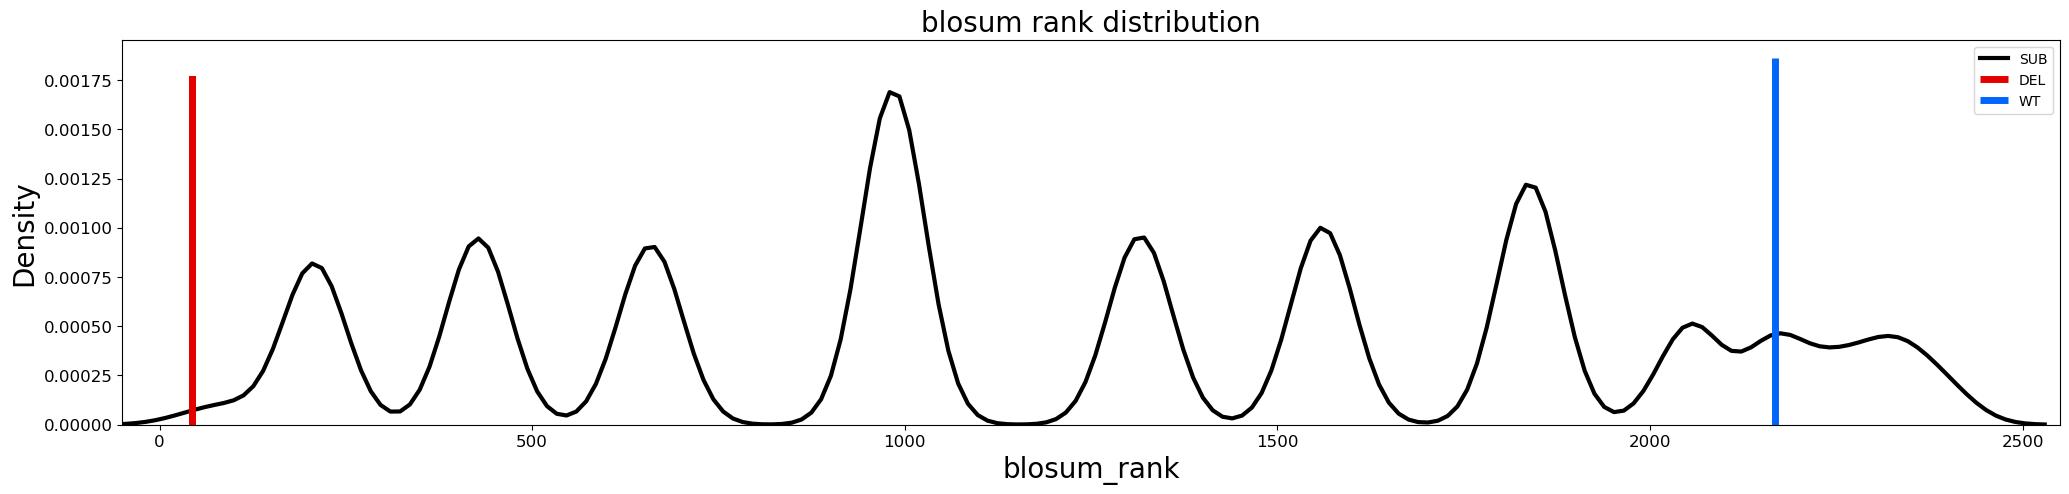

In [9]:
fig, ax = plt.subplots(figsize=(25, 5))
plot_rank_dist(name='blosum', ax=ax, show_del=False)
plt.show()

BLOSUM public score = 0.196

## pLDDT - 0.292

In [10]:
# Read AlphaFold2 result for wild type sequence:
plddt = (
    pd.read_csv('data/wildtype_structure_prediction_af2.pdb', sep='\s+', header=None)[[0,5,10]]
    .rename(columns={0:'atom', 5:'resid', 10:'plddt'})
    .query('atom=="ATOM"')
    .drop_duplicates()
)

# Add B factor to the testing set:
test_df = pd.merge(
    test_df,
    plddt,
    left_on='resid',
    right_on='resid',
    how='left'
)

test_df['plddt_rank'] = rankdata(-1*test_df['plddt'])

Notice how this method assigns a separate rank to each deletion:

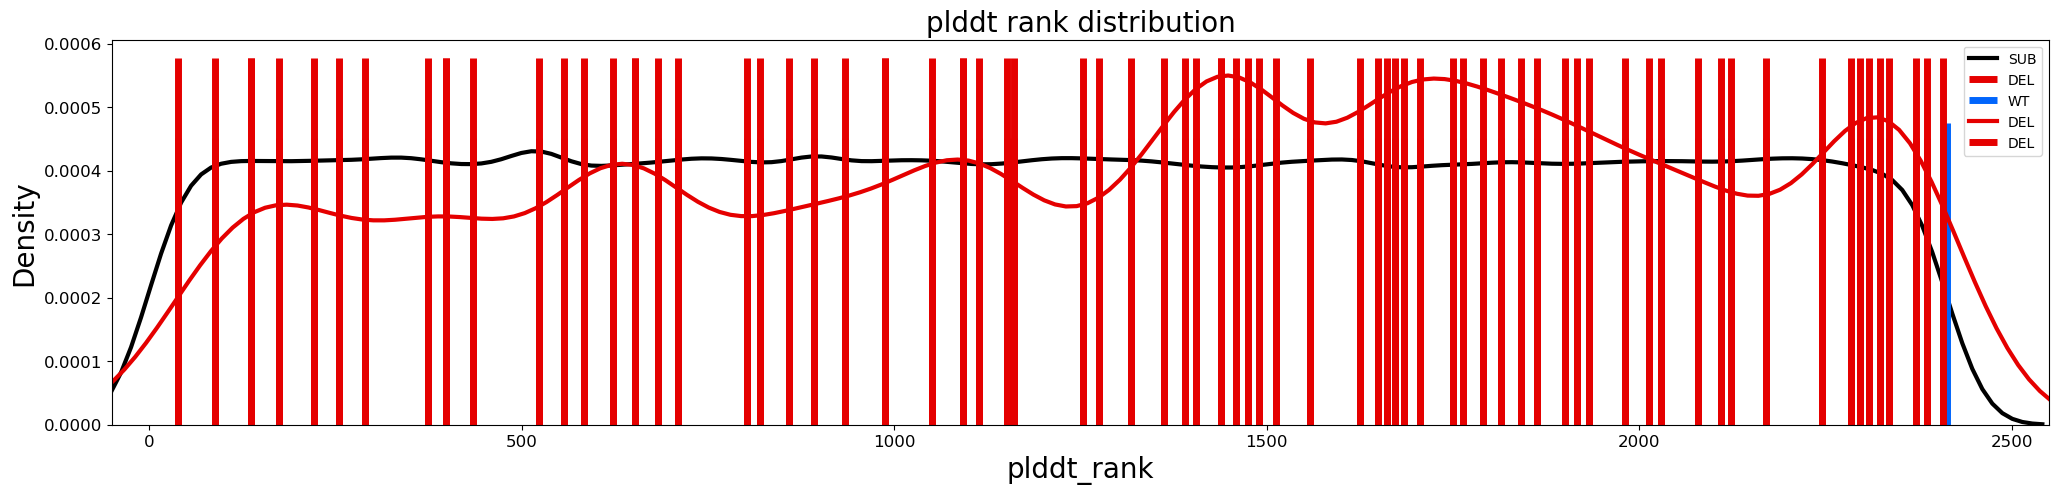

In [11]:
fig, ax = plt.subplots(figsize=(25, 5))
plot_rank_dist(name='plddt', ax=ax, show_del=True)
plt.show()

pLDDT public score = 0.292

## Differential pLDDT - 0.297

In [12]:
plddtdiff = []

# Wild type result:
wt_plddt = (
    pd.read_csv('data/kvigly-test-mutation-pdbs/WT_unrelaxed_rank_1_model_3.pdb', sep='\s+')
    .loc['ATOM'].reset_index()
    .loc[:, ['level_4', 'MODEL']].drop_duplicates()
    .rename(columns={'level_4':'resid', 'MODEL':'plddt'})
    .astype({'resid':int})
    .set_index('resid')
)

# Add difference in pLDDTto the testing set:>
for _,row in tqdm(test_df.iterrows(), total=test_df.shape[0]):
    file_path = 'data/kvigly-test-mutation-pdbs/{}{}{}_unrelaxed_rank_1_model_3.pdb'.format(row['wt'], row['resid'], row['mut'])
    if os.path.exists(file_path):
        tdf = (
            pd.read_csv(file_path, sep='\s+')
            .loc['ATOM'].reset_index()
            .loc[:, ['level_4', 'MODEL']].drop_duplicates()
            .rename(columns={'level_4':'resid', 'MODEL':'plddt'})
            .astype({'resid':int})
            .set_index('resid')
        )
        plddtdiff.append((tdf.loc[row['resid']] - wt_plddt.loc[row['resid']]).values[0])
    else:
        plddtdiff.append(np.nan)

test_df['plddtdiff'] = plddtdiff
test_df['plddtdiff_rank'] = rankdata(test_df['plddtdiff'])

  0%|          | 0/2413 [00:00<?, ?it/s]

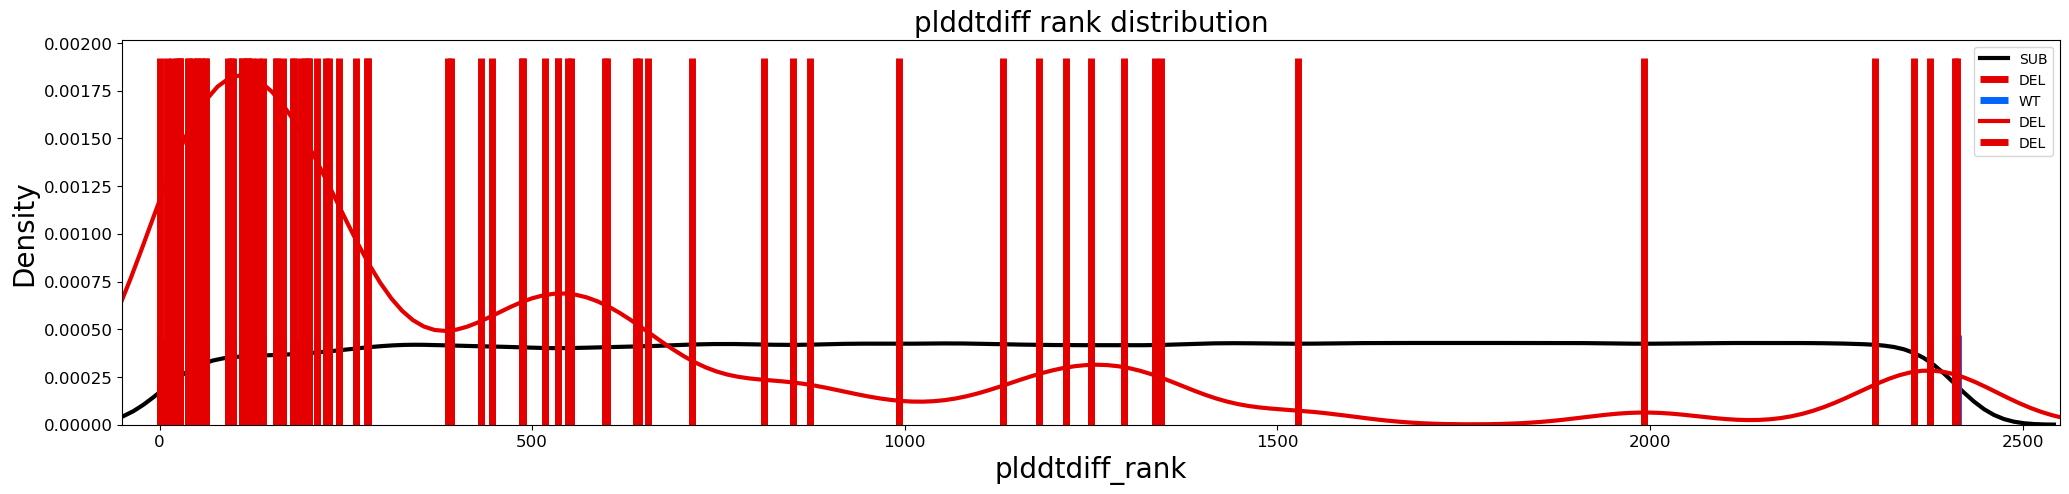

In [13]:
fig, ax = plt.subplots(figsize=(25, 5))
plot_rank_dist(name='plddtdiff', ax=ax, show_del=True)
plt.show()

Differential pLDDT public score = 0.297

## DeepDDG - 0.361

In [14]:
# Run DeepDDG on http://protein.org.cn/ddg.html by uploading the PDB file and clicking "Submit":>
ddg = pd.read_csv('data/deepddg/ddgout.txt', sep='\s+', usecols=[0,1,2,3,4]).rename(columns={'WT':'wt', 'ResID':'resid', 'Mut':'mut'})

# Add DeepDDG output to the testing set:
test_df = pd.merge(
    test_df.set_index(['wt','resid','mut']),
    ddg.set_index(['wt','resid','mut']),
    left_index=True,
    right_index=True,
    how='left'
).reset_index()

test_df.loc[test_df['type']=='WT','ddG'] = 0
test_df.loc[test_df['type']=='DEL','ddG'] = test_df['ddG'].dropna().median()

test_df['ddG_rank'] = rankdata(test_df['ddG'])

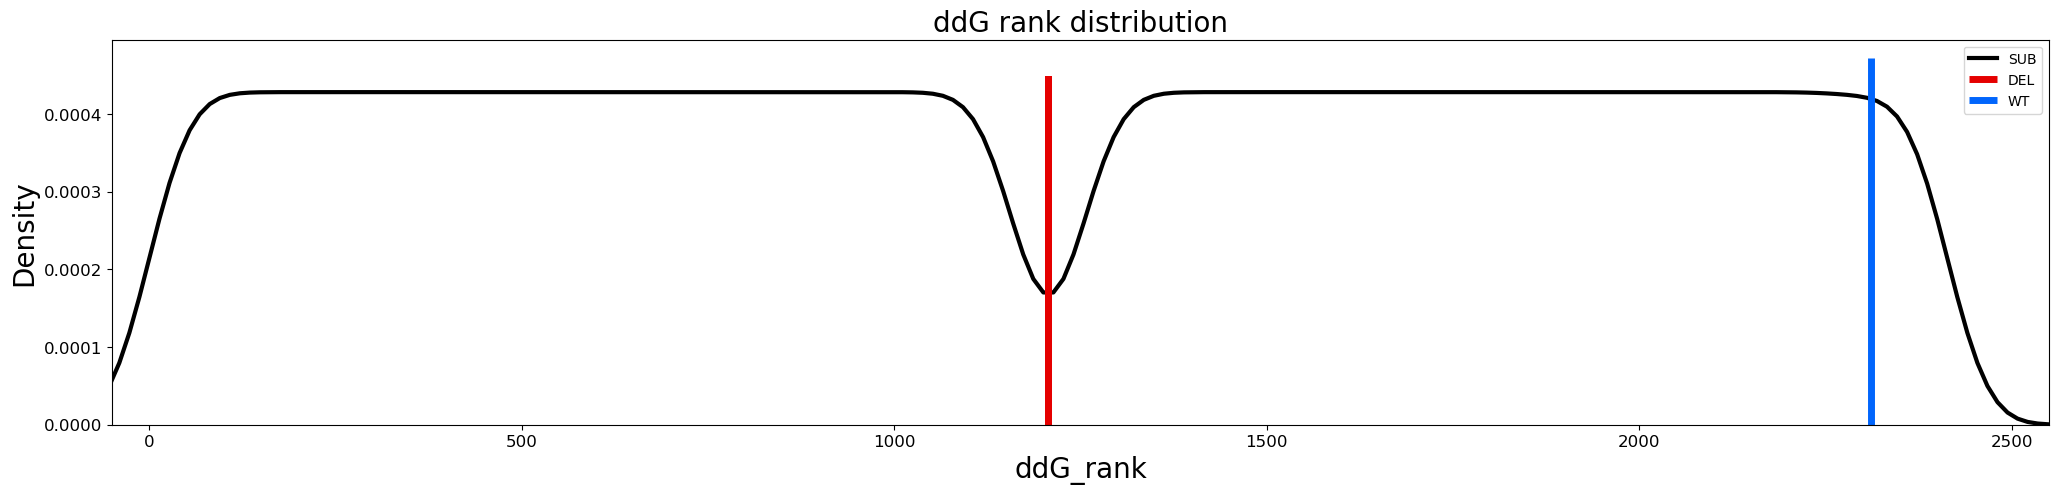

In [15]:
fig, ax = plt.subplots(figsize=(25, 5))
plot_rank_dist(name='ddG', ax=ax, show_del=False)
plt.show()

DDG public score = 0.361

## DeMaSk - 0.363

In [16]:
# Run DeMaSk on https://demask.princeton.edu/query/ by pasting the wild type sequence and clicking "Compute":
demask = pd.read_csv('data/demask/demaskout.txt', sep='\t', usecols=[0,1,2,3], names=['resid','wt','mut','demask'], skiprows=1)

# Add DeMask output to the testing set:
test_df = pd.merge(
    test_df.set_index(['wt','resid','mut']),
    demask.set_index(['wt','resid','mut']),
    left_index=True,
    right_index=True,
    how='left'
).reset_index()

test_df.loc[test_df['type']=='WT','demask'] = 0
test_df.loc[test_df['type']=='DEL','demask'] = test_df['demask'].dropna().min()


test_df['demask_rank'] = rankdata(test_df['demask'])

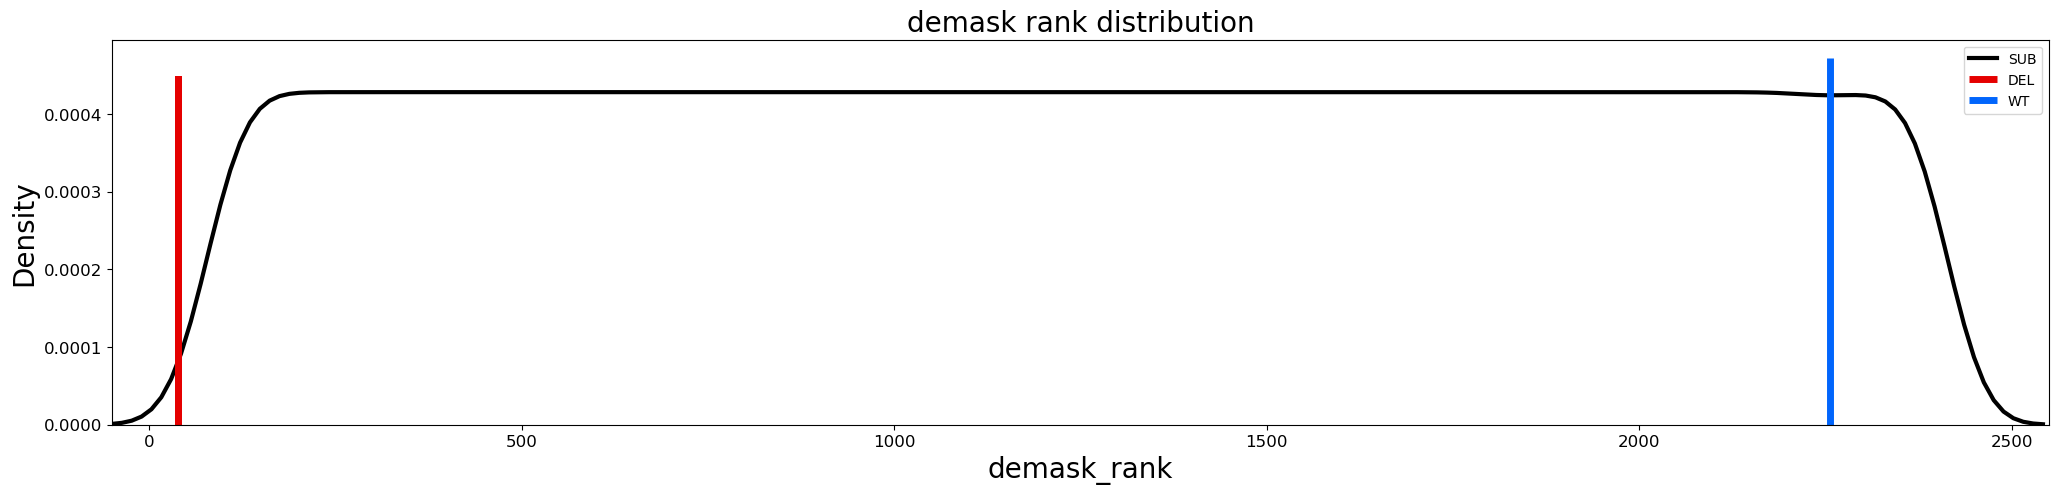

In [17]:
fig, ax = plt.subplots(figsize=(25, 5))
plot_rank_dist(name='demask', ax=ax, show_del=False)
plt.show()

DeMaSk public score = 0.363

## RMSD - 0.393

In [18]:
# Read VMD/NAMD output:
namd = pd.read_csv('data/md_2/residue_rmsd_sasa_last.dat', sep='\t', header=None, names=['resid','rmsd','sasa0','sasaf'])

# Add VMD/NAMD results to the testing set:
test_df = pd.merge(
    test_df,
    namd[['resid','rmsd']],
    left_on='resid',
    right_on='resid',
    how='left'
)

test_df.loc[test_df['type']=='WT','rmsd'] = test_df['rmsd'].dropna().max()
# test_df.loc[test_df['type']=='WT','sasaf'] = test_df['sasaf'].dropna().max()

test_df['rmsd_rank'] = rankdata(test_df['rmsd'])
# test_df['sasaf_rank'] = rankdata(test_df['sasaf'])

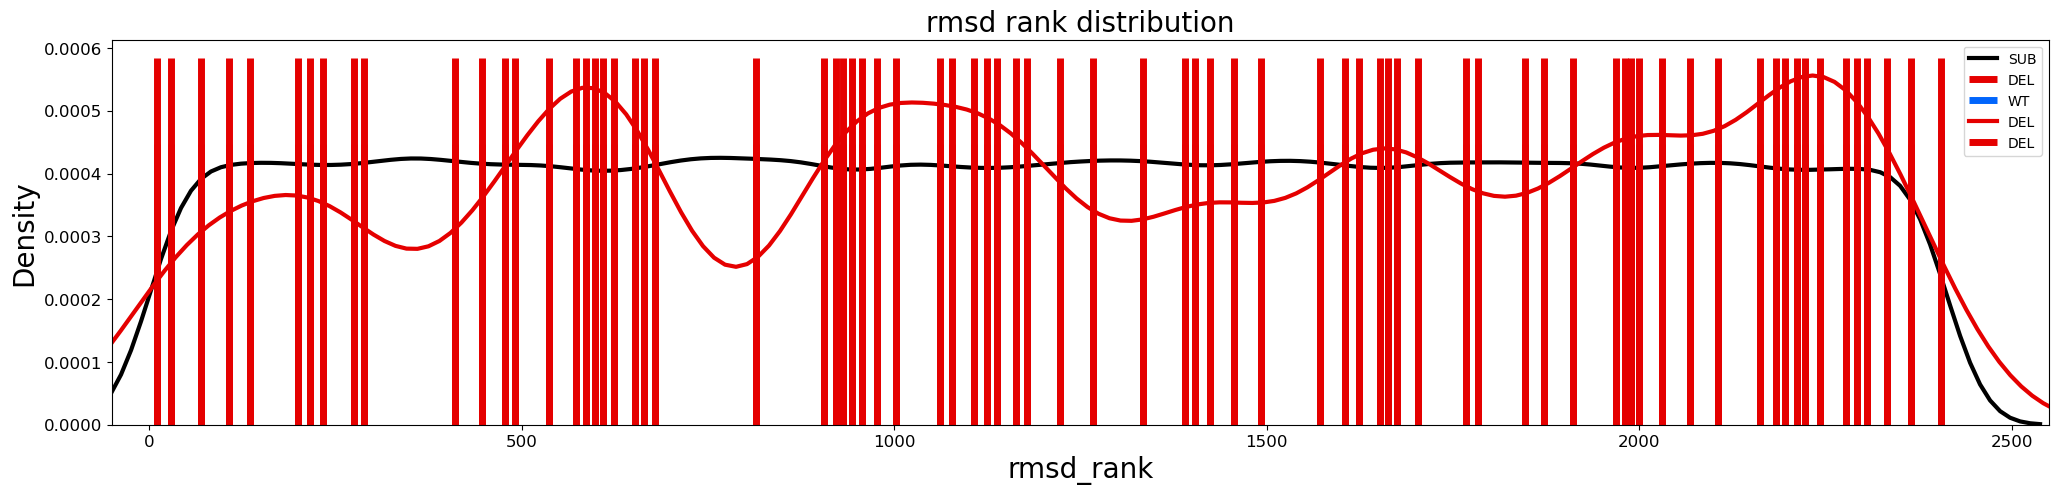

In [19]:
fig, ax = plt.subplots(figsize=(25, 5))
plot_rank_dist(name='rmsd', ax=ax, show_del=True)
plt.show()

RMSD public score = 0.393

In [20]:
namd

,resid,rmsd,sasa0,sasaf
0,1,1.774145,198.432281,161.419312
1,2,1.656036,116.322868,115.720192
2,3,1.948815,134.644394,150.647171
3,4,2.296046,140.815231,91.828255
4,5,1.398716,119.585098,123.152199
...,...,...,...,...
216,217,0.885676,60.894875,72.163391
217,218,0.925841,97.304672,88.281517
218,219,0.615628,28.972021,41.354168
219,220,0.672172,21.619684,20.294685


## SASA - 0.408

In [21]:
# Read VMD/NAMD output:
namd = pd.read_csv('data/sasa_md/residue_rmsd_sasa_last.dat', sep='\t', header=None, names=['resid','rmsd','sasa0','sasaf'])

# Add VMD/NAMD results to the testing set:
test_df = pd.merge(
    test_df,
    namd[['resid','sasaf']],
    left_on='resid',
    right_on='resid',
    how='left'
)

# test_df.loc[test_df['type']=='WT','rmsd'] = test_df['rmsd'].dropna().max()
test_df.loc[test_df['type']=='WT','sasaf'] = test_df['sasaf'].dropna().max()

# test_df['rmsd_rank'] = rankdata(test_df['rmsd'])
test_df['sasaf_rank'] = rankdata(test_df['sasaf'])

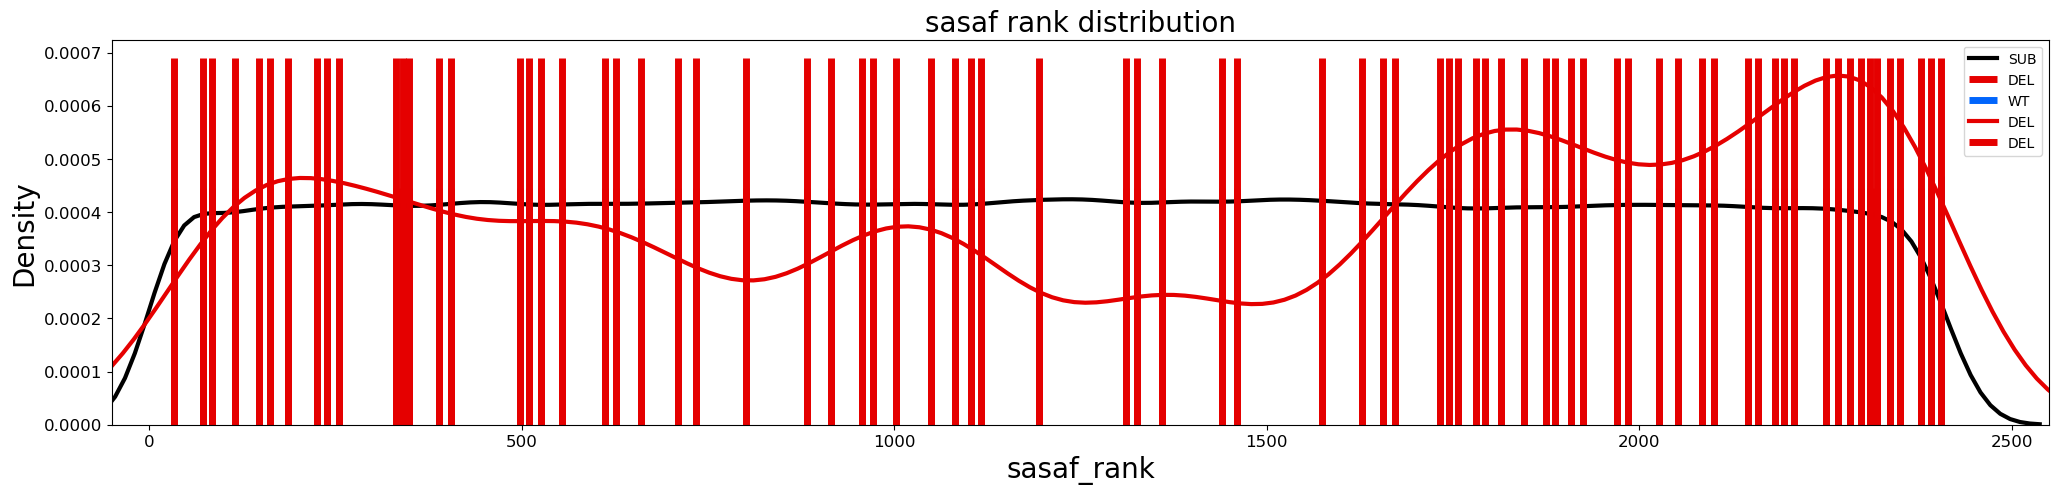

In [22]:
fig, ax = plt.subplots(figsize=(25, 5))
plot_rank_dist(name='sasaf', ax=ax, show_del=True)
plt.show()

SASA public score = 0.408

## Rosetta - 0.471

In [23]:
test_df['rosetta_rank'] = pd.read_csv('data/rosetta/submission_rosetta_scores')['tm']

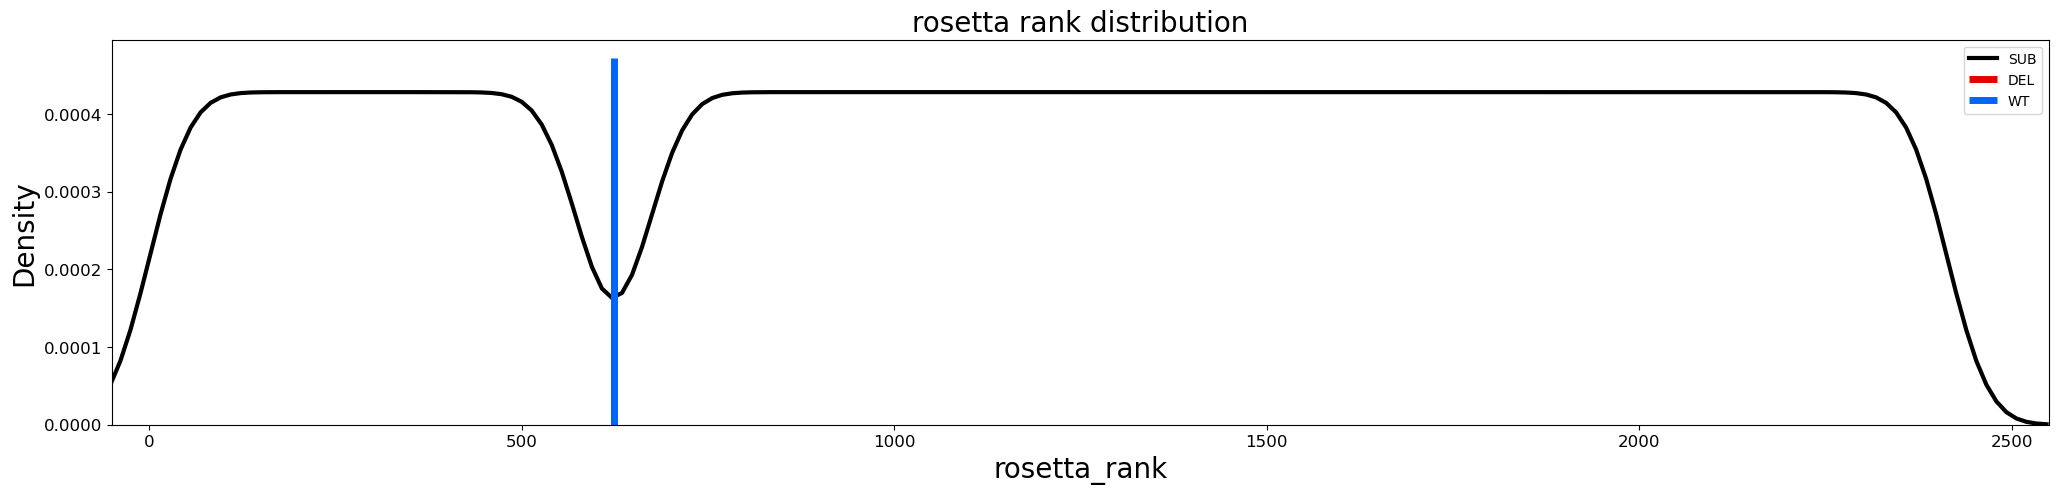

In [24]:
fig, ax = plt.subplots(figsize=(25, 5))
plot_rank_dist(name='rosetta', ax=ax, show_del=False)
plt.show()

Rosetta public score = 0.471

## Thermonet - 0.494

In [25]:
test_df['thermonet'] = pd.read_csv('data/thermonet/submission.csv')['tm']
test_df['thermonet_rank'] = rankdata(test_df['thermonet'])

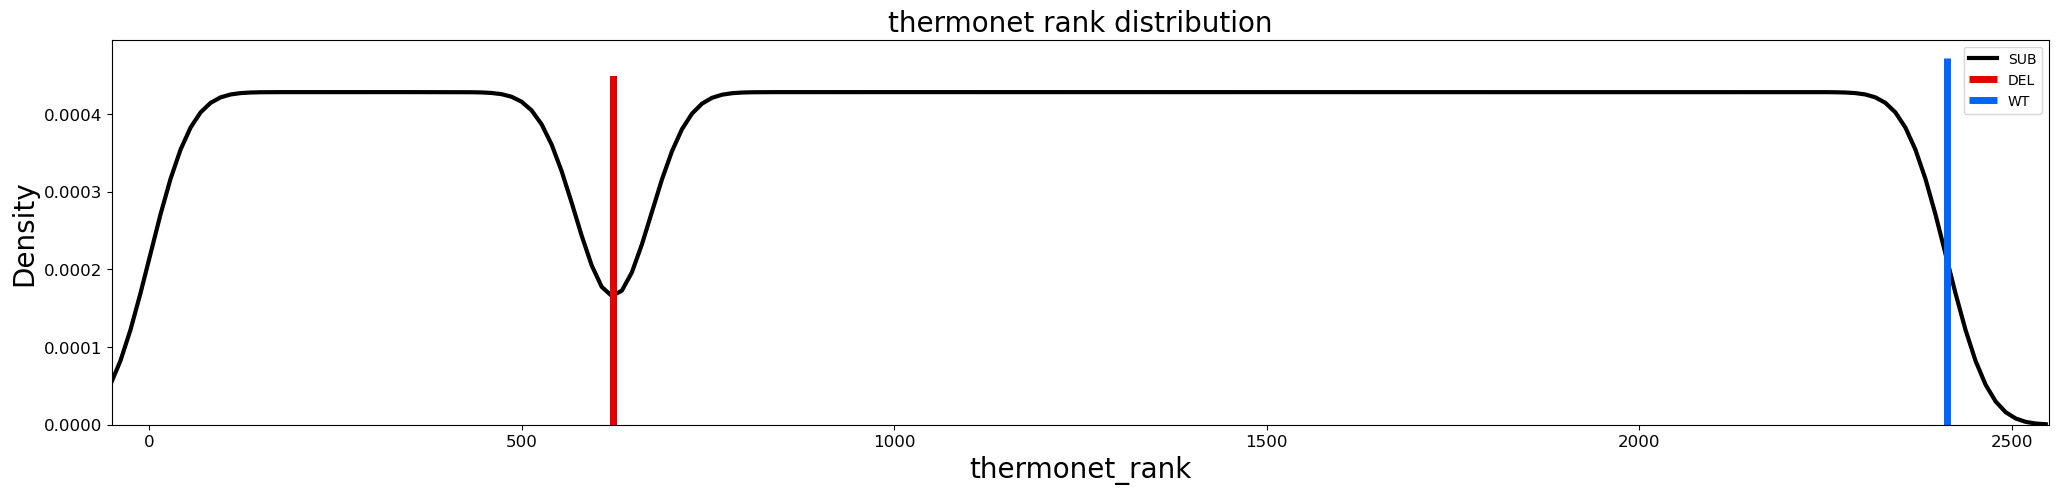

In [26]:
fig, ax = plt.subplots(figsize=(25, 5))
plot_rank_dist(name='thermonet', ax=ax, show_del=False)
plt.show()

Thermonet public score = 0.494

## EVMutation - 0.264

In [27]:
test_df['ev_mutation'] = pd.read_csv('data/ev/submission.csv')['tm']
test_df['ev_mutation_rank'] = rankdata(test_df['ev_mutation'])

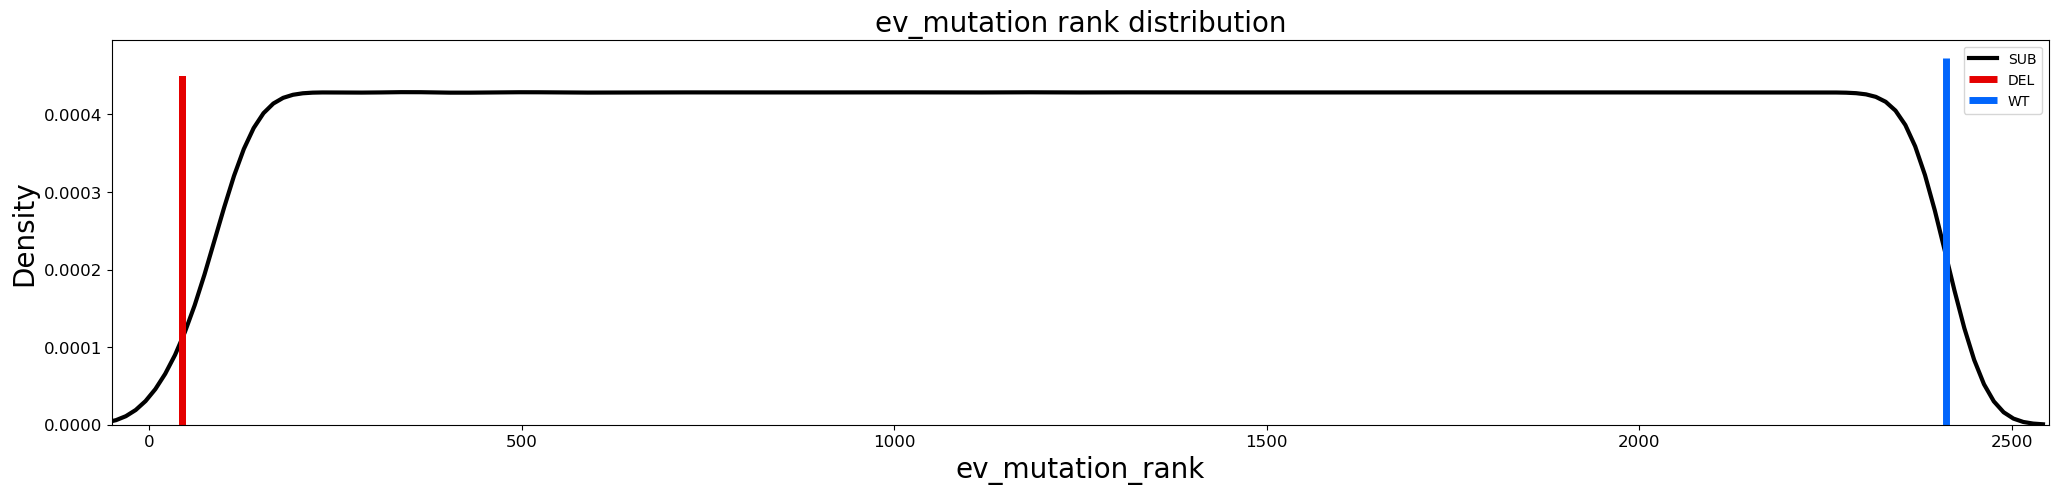

In [28]:
fig, ax = plt.subplots(figsize=(25, 5))
plot_rank_dist(name='ev_mutation', ax=ax, show_del=False)
plt.show()

## MutCompute - 0.366

In [29]:
test_df['mutcompute'] = pd.read_csv('data/mc/submission.csv')['tm']
test_df['mutcompute_rank'] = rankdata(test_df['mutcompute'])

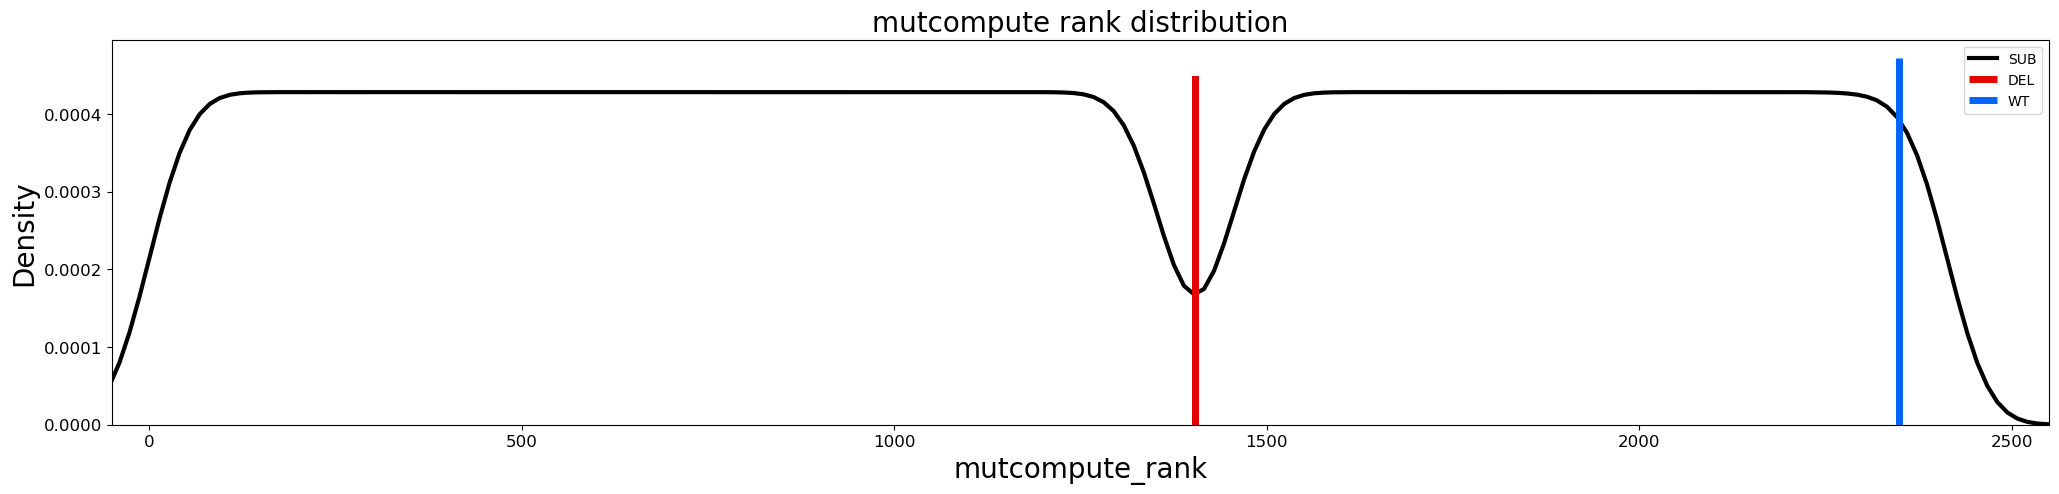

In [30]:
fig, ax = plt.subplots(figsize=(25, 5))
plot_rank_dist(name='mutcompute', ax=ax, show_del=False)
plt.show()

# Analyze scores

## Visualize scores

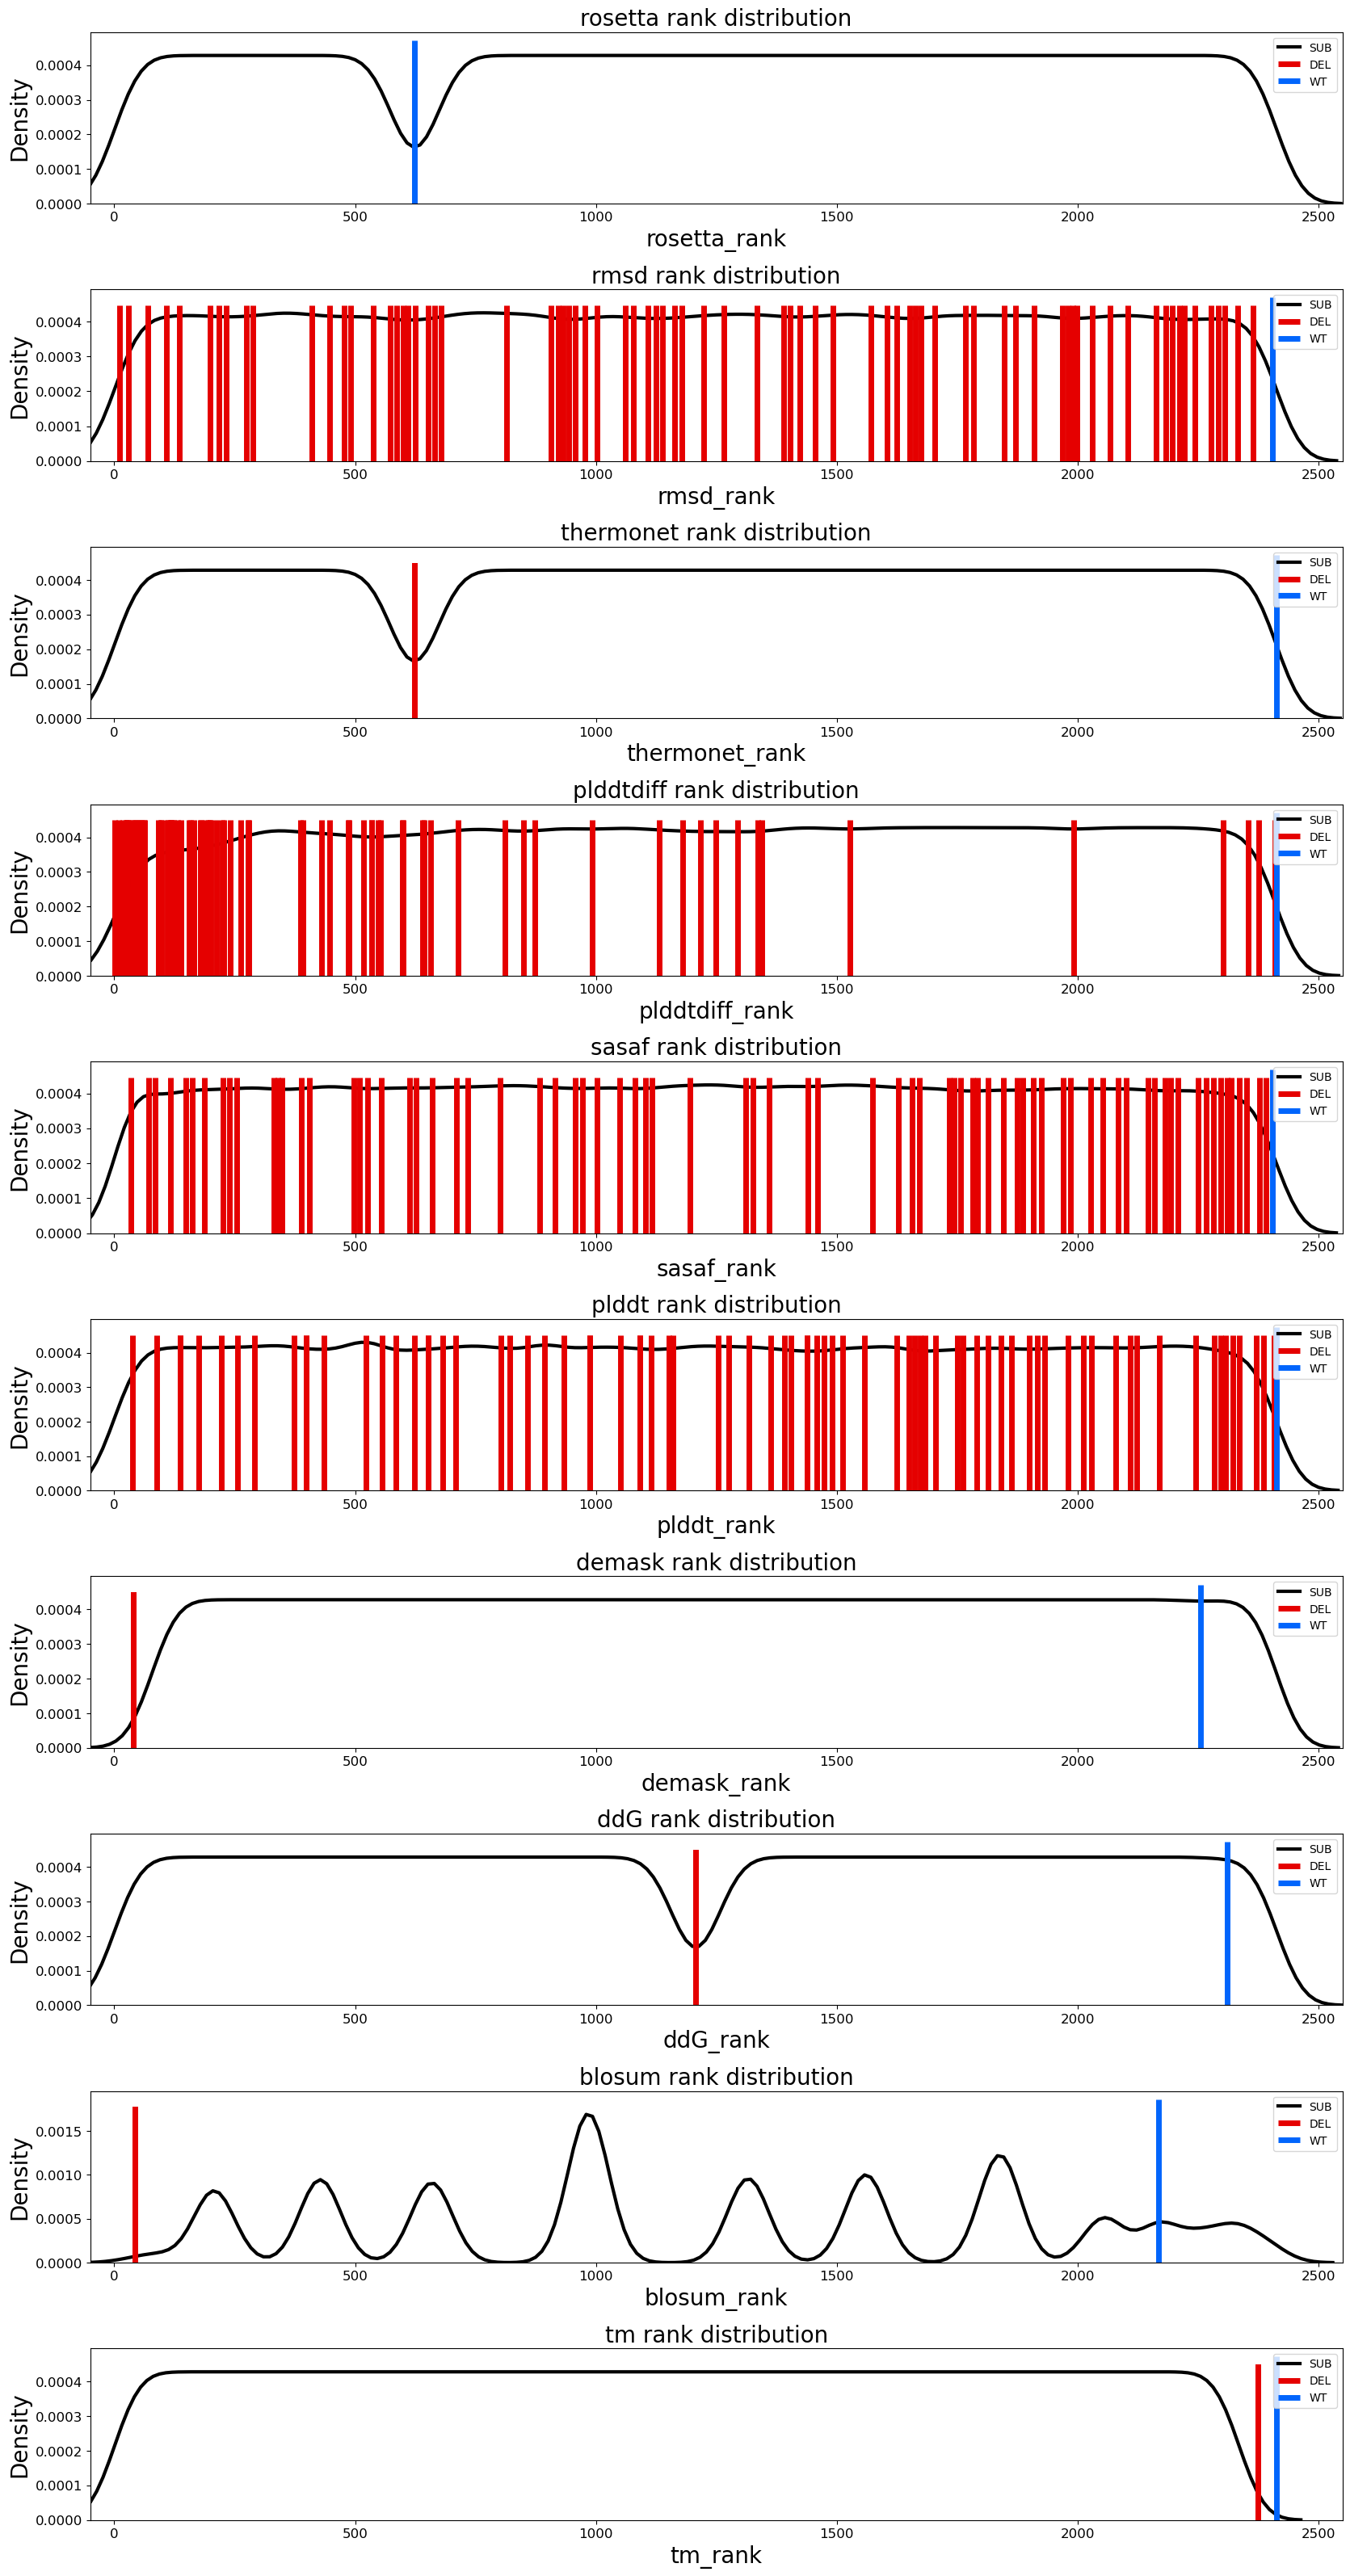

In [124]:
fig, axs = plt.subplots(nrows=10, figsize=(20,40), gridspec_kw={'hspace':0.5})


plot_rank_dist(name='rosetta', ax=axs[0], show_del=False)
plot_rank_dist(name='rmsd', ax=axs[1], show_del=False)
plot_rank_dist(name='thermonet', ax=axs[2], show_del=False)
plot_rank_dist(name='plddtdiff', ax=axs[3], show_del=False)
plot_rank_dist(name='sasaf', ax=axs[4], show_del=False)
plot_rank_dist(name='plddt', ax=axs[5], show_del=False)
plot_rank_dist(name='demask', ax=axs[6], show_del=False)
plot_rank_dist(name='ddG', ax=axs[7], show_del=False)
plot_rank_dist(name='blosum', ax=axs[8], show_del=False)
plot_rank_dist(name='tm', ax=axs[9], show_del=False)

plt.show()

/home/xux/miniconda3/envs/prot-gen-env/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


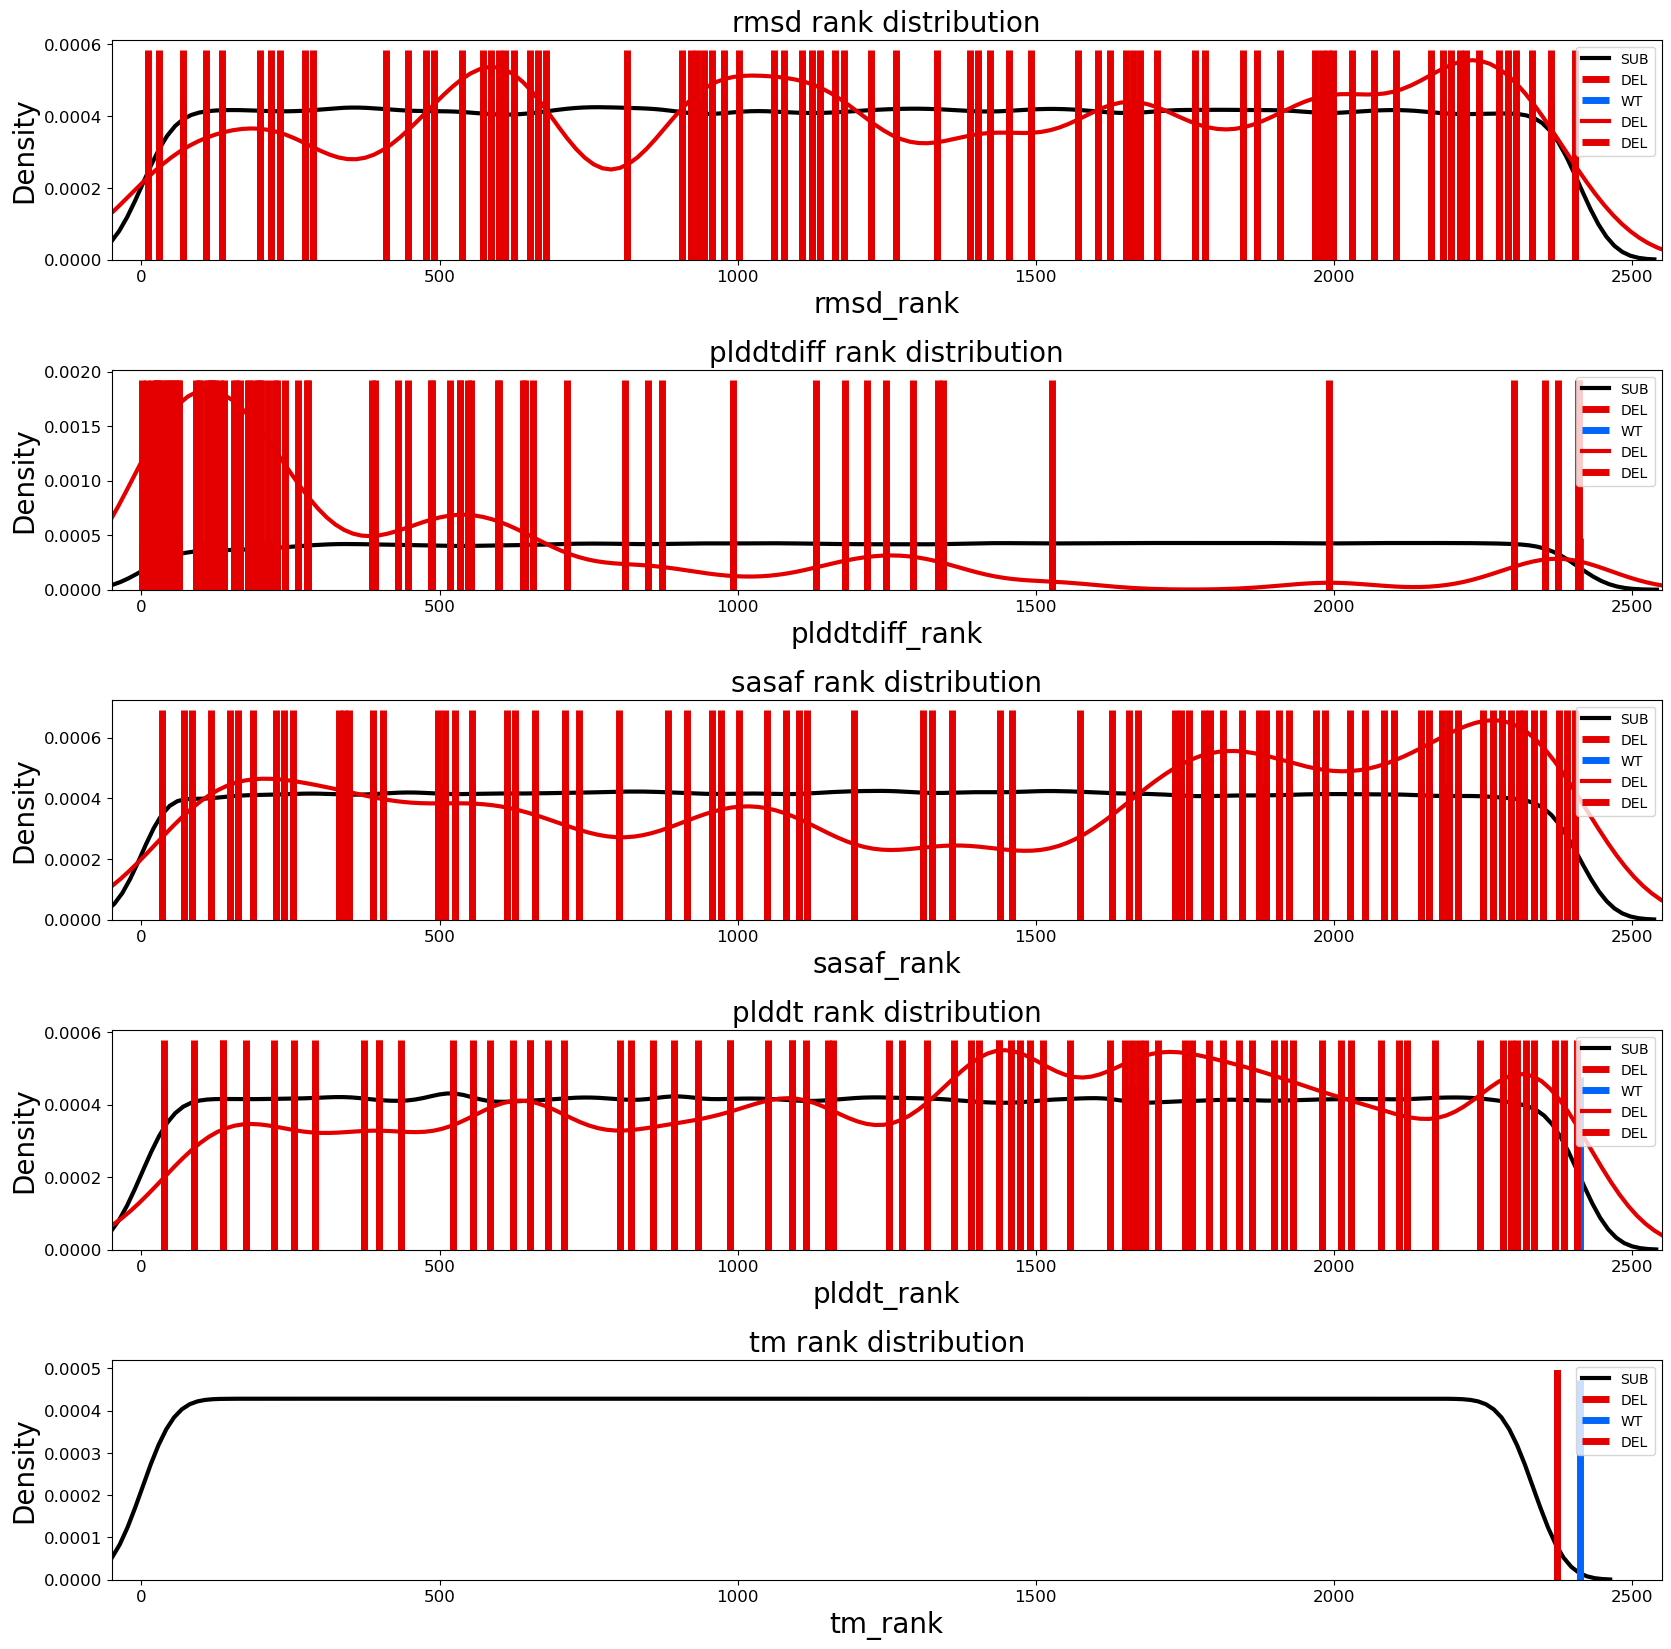

In [125]:
fig, axs = plt.subplots(nrows=5, figsize=(20,20), gridspec_kw={'hspace':0.5})


# plot_rank_dist(name='rosetta', ax=axs[0], show_del=False)
plot_rank_dist(name='rmsd', ax=axs[0], show_del=True)
# plot_rank_dist(name='thermonet', ax=axs[2], show_del=False)
plot_rank_dist(name='plddtdiff', ax=axs[1], show_del=True)
plot_rank_dist(name='sasaf', ax=axs[2], show_del=True)
plot_rank_dist(name='plddt', ax=axs[3], show_del=True)
# plot_rank_dist(name='demask', ax=axs[6], show_del=False)
# plot_rank_dist(name='ddG', ax=axs[7], show_del=False)
# plot_rank_dist(name='blosum', ax=axs[8], show_del=False)

plot_rank_dist(name='tm', ax=axs[4], show_del=True)

plt.show()

## Analyze correlations of scores

In [195]:
from scipy.stats import spearmanr

def plot_spearmanr_matrix(cols, m_type=None):
    tmp_df = test_df if not m_type else test_df[test_df['type']==m_type]
        
    n = len(cols)
    spearmanr_matrix = np.ones((n, n))
    for i in range(n-1):
        for j in range(i+1, n):
            rho, _= spearmanr(tmp_df[cols[i]+'_rank'], tmp_df[cols[j]+ '_rank']) 
            spearmanr_matrix[i, j] = spearmanr_matrix[j, i] = rho
    # return spearmanr_matrix
    
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(spearmanr_matrix)

    ax.set_xticks(np.arange(n), labels=cols)
    ax.set_yticks(np.arange(n), labels=cols)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    for i in range(n):
        for j in range(n):
            text = ax.text(j, i, round(spearmanr_matrix[i, j], 2), ha="center", va="center", color="w")

    ax.set_title("Spearmanr of columns")
    fig.tight_layout()
    plt.show()

In [196]:
test_df.type.unique()

array(['SUB', 'DEL', 'WT'], dtype=object)

### Substitutions

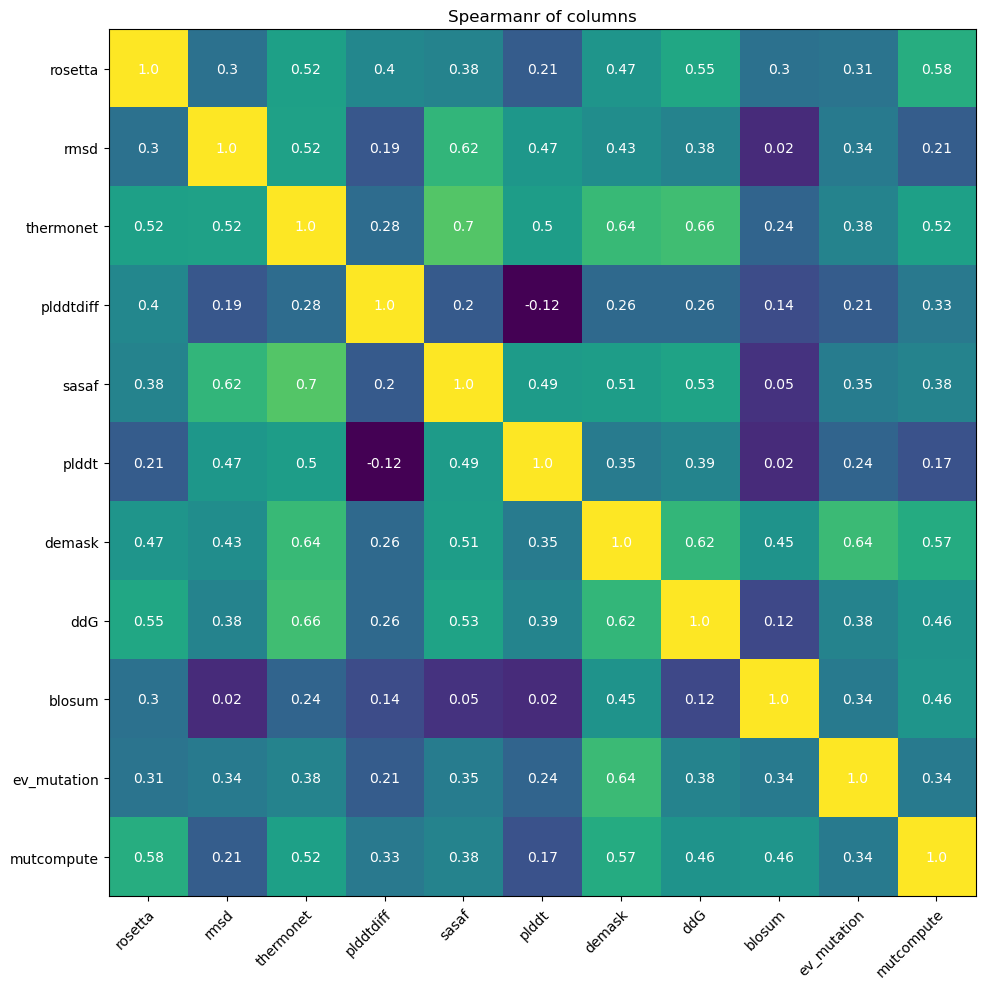

In [197]:
plot_spearmanr_matrix([ 'rosetta', 'rmsd', 'thermonet', 'plddtdiff', 
    'sasaf', 'plddt', 'demask', 'ddG', 'blosum', 'ev_mutation', 'mutcompute'
], m_type='SUB')

Observations: (pos: >=0.4, neg: <= -0.1, independent: -0.1~0.1, weak pos: 0.1 ~ 0.4)
- rosetta: mutcompute, ddG, thermonet, demask and plddtdiff are positively correlated, week pos with rest
- rmsd: sasaf, thermonet, plddt, demask are positively correlated; iid with plddtdiff and blosum; 
- thermonet: positively correlated with all but plddtdiff and blosum (weak)
- plddtdiff: post with rosetta; neg with plddt; weak with rest,
- sasaf: pos with rmsd, thermonet, plddt, demask, ddG; iid with blosum; weak with rest (rosetta, plddtdiff, ev, mc)
- plddt: pos with rmsd, thermonet, sasaf, neg with plddtdiff, iid with blosum; weak with rest (rosetta, demask, ddG,  ev, mc)
- demask: pos with rosetta, rmsd, thermonet, sasaf, ddG, blosum, ev_mutation, mutcompute
- ddG: pos with rosetta, thermonet, sasaf, mc; iid blosum
- bolsum: pos with ev, mc; iid with rmsd, sasaf, plddt, ddG
- ev: pos with thermonet, demask, blosum, 
- mc: pos with rosetta, thermonet, demask, ddG, blosum

### Deletions

In [200]:
def analyze_col(col, m_type='DEL'):
    return test_df[test_df['type']==m_type][col+ '_rank'], test_df[col+ '_rank'].max(), test_df[test_df['type']==m_type][col+ '_rank'].unique()

In [201]:
# analyze_col('plddtdiff', m_type='DEL')

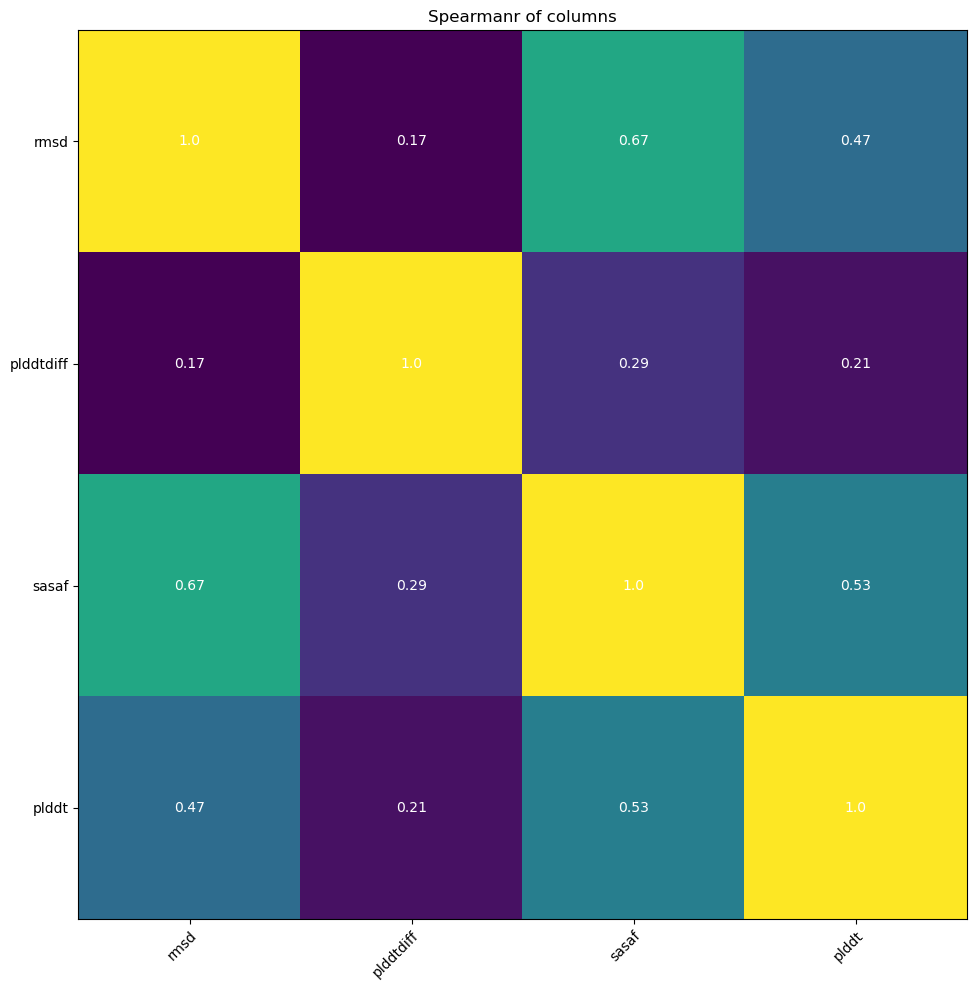

In [202]:
plot_spearmanr_matrix(['rmsd', 'plddtdiff', 'sasaf', 'plddt' ], m_type='DEL')

Observations: (pos: >=0.4, neg: <= -0.1, independent: -0.1~0.1, weak pos: 0.1 ~ 0.4)
- Only four columns has none static values for deletions, rmsd, plddtdiff, sasaf, and plddt
- rmsd, sasaf and plddt are positively correlated
- plddtdiff is weakly correlated with others

### Wild-type

- End: rmsd, thermonet, plddtdiff, sasaf, plddt
- Bad: rosetta

In [221]:
def analyze_wt(col, m_type='DEL'):
    return test_df[test_df['type']==m_type][col+ '_rank'].values[0], test_df[col+ '_rank'].max()

In [222]:
analyze_col('rosetta', m_type='WT')

(array([623.5]), 2413.0)

In [223]:
analyze_col('demask', m_type='WT')

(array([2255.5]), 2413.0)

In [224]:
analyze_col('ddG', m_type='WT')

(array([2311.5]), 2413.0)

In [225]:
analyze_col('blosum', m_type='WT')

(array([2168.]), 2402.0)

In [226]:
analyze_col('ev_mutation', m_type='WT')

(array([2412.]), 2413.0)

In [227]:
analyze_col('mutcompute', m_type='WT')

(array([2348.]), 2413.0)

# Ensembling

In [31]:
def rank_nrom(name):
    s = test_df['{}_rank'.format(name)]
    return s/s.max()

## Substituttion

In [261]:
# Scale ranks prior to ensembling:
# Global ensemble:

test_df['tm'] = (
    4 * rank_nrom('rosetta') + 2*rank_nrom('rmsd') + 2*rank_nrom('thermonet') + 2*rank_nrom('plddtdiff') +\
    rank_nrom('sasaf') + rank_nrom('plddt') + rank_nrom('demask') + rank_nrom('ddG') + rank_nrom('blosum') + rank_nrom('ev_mutation')
) #/ 14

#  + rank_nrom('mutcompute') : 0.601; + 0.5*rank_nrom('mutcompute') : 0.602 -- conclusion: adding mutcompute doesn't improve the results
#  + rank_nrom('ev_mutation') : 0.599 -- conclusion: adding ev_mutation directly doesn't improve the results

# test_df['tm'] = (
#     0.471*rank_nrom('rosetta') + 0.393*rank_nrom('rmsd') + 0.494*rank_nrom('thermonet') + 0.297*rank_nrom('plddtdiff') + \
#     0.408*rank_nrom('sasaf') + 0.292*rank_nrom('plddt') + 0.363*rank_nrom('demask') + 0.361*rank_nrom('ddG') + 0.196*rank_nrom('blosum') + 0.264*rank_nrom('ev_mutation') + 0.366*rank_nrom('mutcompute')
# )
#  0.536 -- conclusion: merging simply by the resulting scores as coefficients doesn't improve the results

# Consider using mutcompute+onehot as predictors to predict the resulting value? Not good, because it mainly using ev info + onehot representation. 
# It can be seen as a form of distilation. After training, it preserves few learned knowledge. But easier to be used in other applications.

test_df['tm'] = test_df['tm']/test_df['tm'].max()

In [253]:
test_df['tm'].max(),test_df['tm'].min()

(1.0, 0.08585387011256276)

## Deletion

In [254]:
# Deletion type:

# test_df.loc[test_df['type']=="DEL",'tm'] = test_df['tm'].max() + 1

idx = test_df[test_df['type']=="DEL"].index
test_df.loc[idx, 'tm'] =  (2*rank_nrom('plddt')[idx] + 2*rank_nrom('plddtdiff')[idx] + rank_nrom('rmsd')[idx] + rank_nrom('sasaf')[idx]) / 6  # PDB structures are usefulf for deletion types, rmsd & sasaf not good?

# test_df.loc[idx, 'tm'] =  (4*0.292*rank_nrom('plddt')[idx] + 4*0.297*rank_nrom('plddtdiff')[idx] + 0.393*rank_nrom('rmsd')[idx] + 0.408*rank_nrom('sasaf')[idx]) / (4*0.292 + 4*0.297 + 0.393 + 0.408)

In [255]:
test_df[test_df['type']=="DEL"]

,wt,resid,mut,seq_id,protein_sequence,pH,data_source,type,blosum,blosum_rank,...,sasaf_rank,rosetta_rank,thermonet,thermonet_rank,ev_mutation,ev_mutation_rank,mutcompute,mutcompute_rank,tm,tm_rank
2,L,17,_,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes,DEL,-10,43.5,...,2319.0,623.5,-2.031553,623.0,807.653817,45.0,-10.0,1404.0,0.985867,2410.0
13,T,19,_,31403,VPVNPEPDATSVENVALKGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes,DEL,-10,43.5,...,1985.5,623.5,-2.031553,623.0,807.653817,45.0,-10.0,1404.0,0.565149,1227.0
56,S,24,_,31446,VPVNPEPDATSVENVALKTGSGDQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes,DEL,-10,43.5,...,1311.0,623.5,-2.031553,623.0,807.653817,45.0,-10.0,1404.0,0.455920,876.0
70,S,26,_,31460,VPVNPEPDATSVENVALKTGSGDSQDPIKADLEVKGQSALPFDVDC...,8,Novozymes,DEL,-10,43.5,...,2146.0,623.5,-2.031553,623.0,807.653817,45.0,-10.0,1404.0,0.495386,1010.0
84,P,28,_,31474,VPVNPEPDATSVENVALKTGSGDSQSDIKADLEVKGQSALPFDVDC...,8,Novozymes,DEL,-10,43.5,...,148.0,623.5,-2.031553,623.0,807.653817,45.0,-10.0,1404.0,0.145550,52.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2340,D,27,_,33730,VPVNPEPDATSVENVALKTGSGDSQSPIKADLEVKGQSALPFDVDC...,8,Novozymes,DEL,-10,43.5,...,1360.0,623.5,-2.031553,623.0,807.653817,45.0,-10.0,1404.0,0.519723,1077.0
2347,Q,25,_,33737,VPVNPEPDATSVENVALKTGSGDSSDPIKADLEVKGQSALPFDVDC...,8,Novozymes,DEL,-10,43.5,...,2208.0,623.5,-2.031553,623.0,807.653817,45.0,-10.0,1404.0,0.610813,1413.0
2363,D,23,_,33753,VPVNPEPDATSVENVALKTGSGSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes,DEL,-10,43.5,...,2194.0,623.5,-2.031553,623.0,807.653817,45.0,-10.0,1404.0,0.613612,1427.0
2381,G,20,_,33771,VPVNPEPDATSVENVALKTSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes,DEL,-10,43.5,...,1049.5,623.5,-2.031553,623.0,807.653817,45.0,-10.0,1404.0,0.498144,1018.0


In [256]:
test_df['tm'].max(),test_df['tm'].min()

(1.0, 0.06361209307748884)

## Wild-type

In [257]:
# Wild type:
test_df.loc[test_df['type']=="WT",'tm'] = test_df['tm'].max() + 1
# test_df.loc[test_df['type']=="WT",'tm'] = test_df.loc[test_df['type']=="WT",'rosetta_rank']/ test_df['rosetta_rank'].max() # 0.572
# test_df.loc[test_df['type']=="WT",'tm'] = test_df.loc[test_df['type']=="WT",'demask_rank']/ test_df['demask_rank'].max()  # 0.597
# test_df.loc[test_df['type']=="WT",'tm'] = test_df.loc[test_df['type']=="WT",'blosum_rank']/ test_df['blosum_rank'].max() # 0.594

## Submitions & plot

In [258]:
test_df['tm'] = rankdata(test_df['tm'])
test_df['tm_rank'] = test_df['tm']

# Submission:
test_df[['seq_id','tm']].to_csv('submissions/ensembl_submission.csv', index=False)

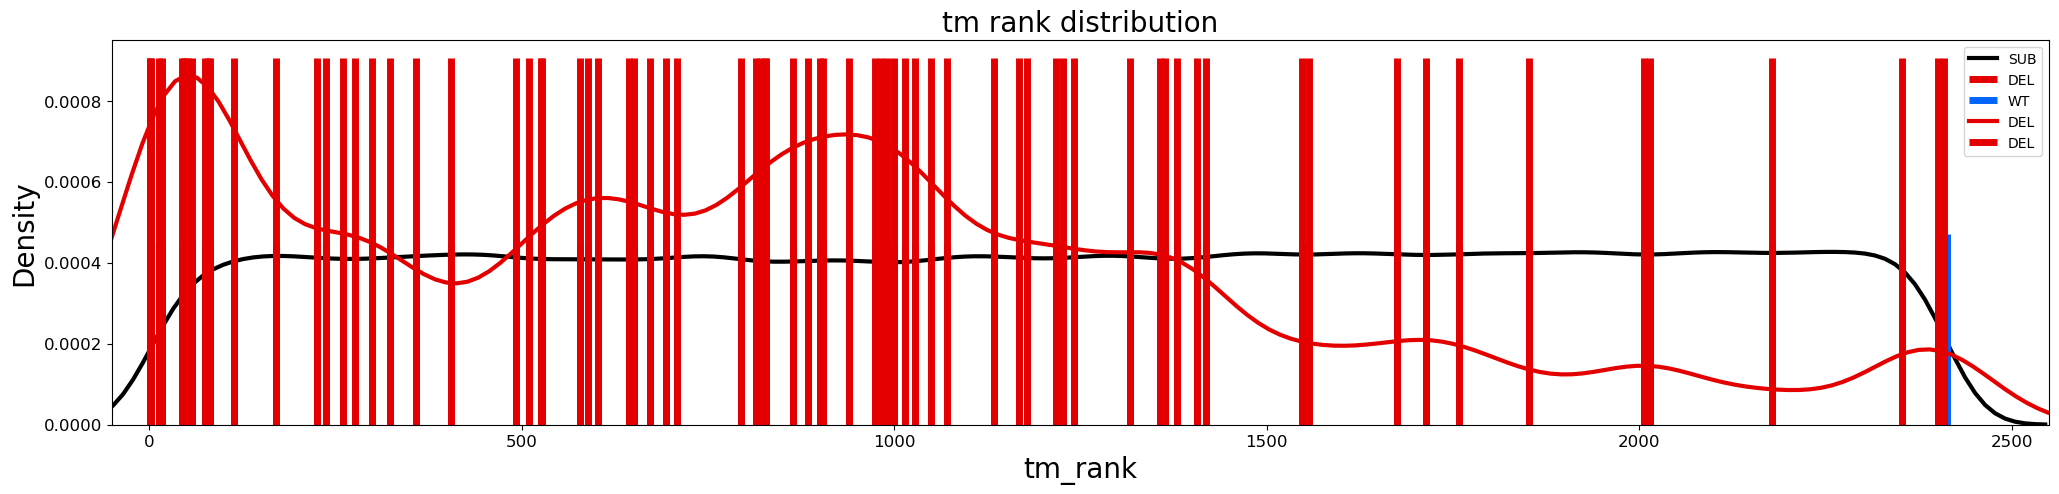

In [259]:
fig, ax = plt.subplots(figsize=(25, 5))
plot_rank_dist(name='tm', ax=ax, show_del=True)
plt.show()